# Genetic Algorithm
**Achievement**

System details for reproducibility

In [1]:
%load_ext watermark
%watermark

2019-11-19T17:22:52+02:00

CPython 3.6.7
IPython 7.8.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-54-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.compat.v1.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation
AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from random import sample
import os
tf.__version__ # Should be 2.0.0

'2.0.0'

In [3]:
from tensorflow.keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

# Using Swish Activation Function
def swish(x):
    return (K.sigmoid(x) * x)

get_custom_objects().update({'swish': Activation(swish)})

In [4]:
# To fix issues with memory segmentation
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

In [5]:
BATCH_SIZE = 16
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [6]:
image_count = 0
CLASS_NAMES = []
for f in os.listdir("../../data/train"):
    if f != 'models':
        CLASS_NAMES.append(f)
        image_count += len(os.listdir(os.path.join("../../data/train", f)))
CLASS_NAMES = np.array(CLASS_NAMES)
print(CLASS_NAMES)
print("Number of Classes:", len(CLASS_NAMES))
print("Number of Images:",image_count)

['class-581' 'class-854' 'class-957' 'class-1625' 'class-804' 'class-639'
 'class-72' 'class-460' 'class-734' 'class-707' 'class-128' 'class-663'
 'class-653' 'class-857' 'class-543' 'class-450' 'class-67' 'class-326'
 'class-78' 'class-273' 'class-508' 'class-239' 'class-1059' 'class-4'
 'class-540' 'class-771' 'class-629' 'class-966' 'class-390' 'class-204'
 'class-697' 'class-784' 'class-536' 'class-337' 'class-872' 'class-394'
 'class-561' 'class-811' 'class-635' 'class-362' 'class-654' 'class-526'
 'class-140' 'class-597' 'class-448']
Number of Classes: 45
Number of Images: 82417


In [7]:
def create_image_batches(data_dir):
    image_count = 0
    for f in os.listdir(data_dir):
        image_count += len(os.listdir(os.path.join(data_dir, f)))
    STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
    list_ds = tf.data.Dataset.list_files(data_dir+"/*/*")
    labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    ds = prepare_for_training(labeled_ds)
    image_batch, label_batch = next(iter(ds))
    show_batch(image_batch.numpy(), label_batch.numpy())
    return ds, STEPS_PER_EPOCH

# Loading Data

In [8]:
data_dir = "../../data/train_data"
test_data_dir = "../../data/val_data"

In [11]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, '/')
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

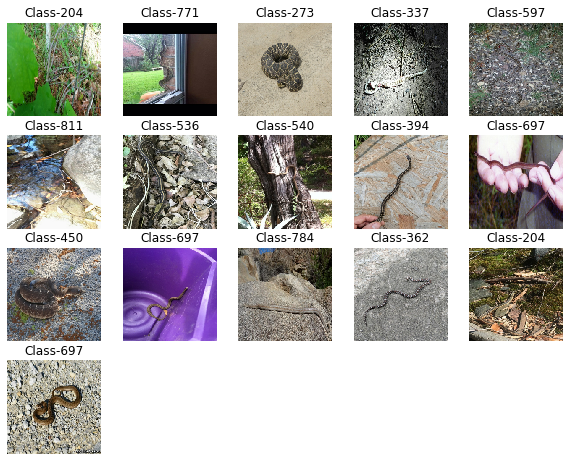

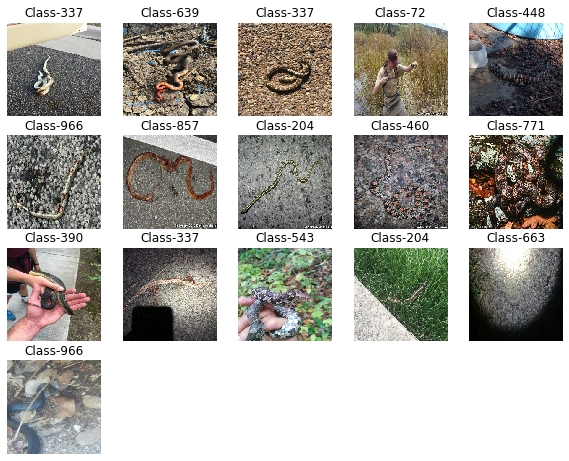

In [12]:
train_batch, train_steps = create_image_batches(data_dir)
test_batch, test_steps = create_image_batches(test_data_dir)

# Hyperparameters to train with

Will need to add more to actually get some headway

In [13]:
activations = ['relu','elu', 'swish']
dropouts = [0.00,0.05,0.10,0.15,0.20]
kernel_sizes = [3,5,7]
num_filters = [8,16,32,64]

In [14]:
class Individual:
    """
    A inidivudal within the population
    """
    def __init__(self, activation, dropout, kernel_size, num_filters, num_classes = 45, verbose=False):
        """
        The possible parameters to tune
        """
        self.activation = activation
        self.dropout = dropout
        self.kernel = kernel_size
        self.filters = num_filters
        self.created = False
        self.model = tf.keras.Sequential()
        self.fitness = 0
        self.verbose = verbose
        self.num_classes = num_classes
        self.num_params = 4
        self.param_list = [activation, dropout, kernel_size, num_filters]
        if self.verbose:
            print("Created individual with following parameters:", self.activation, self.dropout, self.kernel,
                  self.filters)

    def create_model(self):
        """
        Create a model with the necessary parameters
        """
        self.model.add(tf.keras.layers.Conv2D(filters=self.filters, kernel_size=self.kernel, padding='same',
                                              activation=self.activation, input_shape=(224, 224, 3)))
        self.model.add(tf.keras.layers.Dropout(self.dropout))
        self.model.add(tf.keras.layers.Conv2D(filters=self.filters, kernel_size=self.kernel, padding='same',
                                              activation=self.activation))
        self.model.add(tf.keras.layers.Dropout(self.dropout))
        self.model.add(tf.keras.layers.Conv2D(filters=self.filters, kernel_size=self.kernel, padding='same',
                                              activation=self.activation))
        self.model.add(tf.keras.layers.Dropout(self.dropout))
        self.model.add(tf.keras.layers.Flatten())
        self.model.add(tf.keras.layers.Dense(64, activation=self.activation))
        self.model.add(tf.keras.layers.Dropout(self.dropout))
        self.model.add(tf.keras.layers.Dense(self.num_classes, activation='softmax'))
        self.model.compile(loss='categorical_crossentropy',
                           optimizer='adam',
                           metrics=['accuracy'])
        self.created = True

    def train_model(self, num_epochs, train_batch, train_steps):
        """
        Train the created model
        """
        if not self.created:
            self.create_model()
        self.model.fit(train_batch, epochs=num_epochs, steps_per_epoch=train_steps, verbose=self.verbose)  #

    def evaluate_model(self, test_batch,test_steps):
        """
        Evaluate the model on the test data set, and save the fitness
        """
        score = self.model.evaluate(test_batch, steps = test_steps, verbose=self.verbose)
        if self.verbose:
            print(score[1])
        self.fitness = score[1]
        return score[1]

    def print_attributes(self, prefix="", new_line=False):
        if new_line:
            print(prefix, "Activation function:", self.activation, "Dropout:", self.dropout, "Kernel Size:",
                  self.kernel, "Number of Filters:", self.filters, "Fitness:", self.fitness)
        else:
            print(prefix, "Activation function:", self.activation, "Dropout:", self.dropout, "Kernel Size:",
                  self.kernel, "Number of Filters:", self.filters, "Fitness:", self.fitness, end=" ")

In [15]:
class GeneticAlgorithm:
    """
    Make and Monitor Genetic Algorithm
    """

    def __init__(self, generations, pop_size, population, mutation_prob, epochs=2, verbose=False, num_params=4):
        self.generations = generations
        self.pop_size = pop_size
        self.population = population
        self.parent_child = []
        self.mutation_prob = mutation_prob
        self.cache = []
        self.epochs = epochs
        self.verbose = verbose
        self.num_params = num_params
        self.hall_of_fame = []
        if self.verbose:
            print("This GA has", self.generations, "generations, a population size of", self.pop_size,
                  "a mutation probability of", self.mutation_prob, "each individual will run for ", epochs, "epochs")

    def cross_over(self, parent_one, i, parent_two, j):
        """
        Takes in two parents and assigns the first half of the child's parameters
        from the first parent and then the second half from second parent
        """
        child_parameters = []
        crossover_point = int(self.num_params / 2)
        if self.verbose:
            print("Creating child from individuals", i + 1, "&", j + 1)
        for k in range(self.num_params):
            if k < crossover_point:
                child_parameters.append(parent_one.param_list[k])
            else:
                child_parameters.append(parent_two.param_list[k])

        child = Individual(child_parameters[0], child_parameters[1], child_parameters[2], child_parameters[3],
                           self.verbose)
        if self.verbose:
            child.print_attributes(new_line=True)
        return child

    def mutate(self, child):
        """
        Change a single parameter in the child randomly
        """
        random_gene = random.sample([0, 1, 2, 3], 1)[0]
        prev = child.param_list[random_gene]
        if random_gene == 0:
            activations = ['linear', 'relu', 'elu']
            activations.remove(child.param_list[random_gene])
            updated = sample(activations, 1)[0]
            child.activation = updated
            if self.verbose:
                print("Mutating child: changing", prev, "to", updated)
        elif random_gene == 1:
            dropouts = [0.00, 0.05, 0.10, 0.15, 0.20]
            dropouts.remove(child.param_list[random_gene])
            updated = sample(dropouts, 1)[0]
            child.dropout = updated
            if self.verbose:
                print("Mutating child: changing", prev, "to", updated)
        elif random_gene == 2:
            kernel_sizes = [3, 5, 7]
            kernel_sizes.remove(child.param_list[random_gene])
            updated = sample(kernel_sizes, 1)[0]
            child.kernel_sizes = updated
            if self.verbose:
                print("Mutating child: changing", prev, "to", updated)
        elif random_gene == 3:
            num_filters = [8, 16, 32, 64]
            num_filters.remove(child.param_list[random_gene])
            updated = sample(num_filters, 1)[0]
            child.num_filters = updated
            if self.verbose:
                print("Mutating child: changing", prev, "to", updated)
        return child

    def train_gen(self):
        """
        Train the current generations individuals, and sort the individuals by their
        fitness and return fitness of population
        """
        fitness = np.zeros(self.pop_size)
        for i, p in enumerate(self.population):
            if self.verbose:
                prefix = "Individual " + str(i + 1)
                p.print_attributes(prefix, False)
            if p in self.cache:
                fitness[i] = p.fitness
                if self.verbose:
                    print("Individual", i + 1, "in cache", end="\n")
            else:
                if self.verbose:
                    print("", end="\n")
                p.train_model(self.epochs, train_batch, train_steps)
                fitness[i] = p.evaluate_model(test_batch, test_steps)
                self.cache.append(p)
        self.population.sort(key=lambda x: x.fitness, reverse=True)
        self.hall_of_fame.append(self.population[0])
        return fitness

    def cross_and_mutate(self, midpoint):
        """
        Apply sexual crossover & mutation, store the parent child
        relationship in an array and add the child to the population
        """
        for i in range(midpoint):
            parent_one = self.population[i]
            parent_two = self.population[i + 1]
            child = self.cross_over(parent_one, i, parent_two, i + 1)
            if random() < self.mutation_prob:
                child = self.mutate(child)
            rel_one = (parent_one, child)
            rel_two = (parent_two, child)
            self.parent_child.append(rel_one)
            self.parent_child.append(rel_two)
            self.population.append(child)

    def survival(self):
        """
        Survival Algorithm that returns the fittest individual after running
        for the number of generations
        """
        for g in range(self.generations):
            if self.verbose:
                print("Generation: ", g + 1)
            fitness = self.train_gen()
            if self.verbose:
                print("Generation",g+1,"Fitness",np.sort(fitness))
            if g < self.generations - 1:
                mid = int(self.pop_size / 2)
                self.population = self.population[0:mid]
                self.cross_and_mutate(mid)
        self.population.sort(key=lambda x: x.fitness, reverse=True)
        return self.population[0].fitness

In [16]:
def random_individual(verbose=False):
    """
    Return a pseudo-randomly generated individual
    """
    activations = ['relu','elu']
    dropouts = [0.00,0.05,0.10,0.15,0.20]
    kernel_sizes = [3,5,7]
    num_filters = [8,16,32,64]
    return Individual(sample(activations,1)[0], sample(dropouts,1)[0], sample(kernel_sizes,1)[0], sample(num_filters,1)[0], verbose=verbose)


In [17]:
def create_population(pop_size, verbose=False):
    """
    Creates a population of the given size
    """
    population = []
    used_parameters = []
    r = random_individual(verbose=verbose)
    for i in range(pop_size):
        while r.param_list in used_parameters:
            r = random_individual(verbose=verbose)
        used_parameters.append(r.param_list)
        population.append(r)
    return population

In [18]:
verbosity = True
num_generations = 10
pop_size = 50
intelligent = False
population = create_population(pop_size, verbose=verbosity)
parent_child = []
mutation_prob = 0.31
e = 10

Created individual with following parameters: elu 0.05 7 32
Created individual with following parameters: relu 0.05 7 64
Created individual with following parameters: relu 0.1 5 32
Created individual with following parameters: relu 0.05 3 64
Created individual with following parameters: elu 0.2 3 16
Created individual with following parameters: relu 0.0 3 64
Created individual with following parameters: elu 0.0 3 16
Created individual with following parameters: elu 0.05 5 8
Created individual with following parameters: relu 0.2 5 16
Created individual with following parameters: elu 0.1 3 32
Created individual with following parameters: relu 0.15 5 64
Created individual with following parameters: elu 0.05 7 8
Created individual with following parameters: elu 0.05 7 16
Created individual with following parameters: relu 0.0 7 32
Created individual with following parameters: relu 0.0 3 32
Created individual with following parameters: elu 0.0 3 64
Created individual with following parameter

In [19]:
GA = GeneticAlgorithm(num_generations, pop_size, population, mutation_prob, epochs = e, verbose=verbosity)

This GA has 10 generations, a population size of 50 a mutation probability of 0.31 each individual will run for  10 epochs


In [ ]:
GA.survival()

Generation:  1
Individual 1 Activation function: elu Dropout: 0.05 Kernel Size: 7 Number of Filters: 32 Fitness: 0 
Train for 4120.0 steps
Epoch 1/10
1056/4120 [======>.......................] - ETA: 23:25 - loss: 6.6252 - accuracy: 0.0974

In [ ]:
pop = GA.population
for p in pop:
    print(p.fitness)

In [ ]:
hall = GA.hall_of_fame
for i in hall:
    print(i.fitness)